In [2]:
# Import your favourite library
import pennylane as qml

# Import Numpy from PennyLane
from pennylane import numpy as np

# Import the library that you need in order to use your IBM account
# import qiskit_ibm_provider

# IBM_token = #'Your Token Goes Here'

# try:
#     qiskit_ibm_provider.IBMProvider()
# except:
#     qiskit_ibm_provider.IBMProvider.save_account(token=IBM_token, overwrite=True)

expval [ 0.612 -0.488]


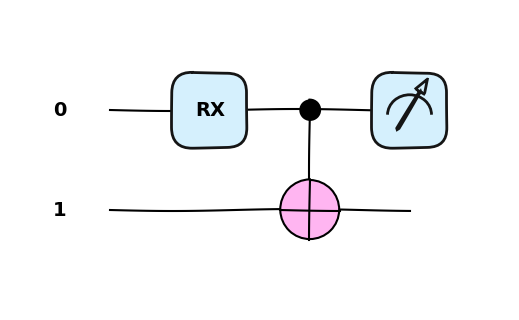

In [31]:
# Choose the device you want to use.
# dev = qml.device("lightning.qubit", wires=2, shots=1000)
dev = qml.device('qiskit.aer', wires=2, shots=1000)
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibmq_qasm_simulator')
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibm_lagos')


# Create a QNode with 2 entangled qubits
@qml.qnode(dev)
def circuit(theta):
    qml.RX(theta,wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(0))

thetas = np.array([1.0,2.0],requires_grad=True)
# Draw your circuit
qml.draw_mpl(circuit,style='pennylane')(thetas)

# Run your circuit
print('expval', circuit(thetas))

In [41]:
def cost(circuit, thetas):
    c = circuit(thetas)
    return np.mean(c) # collapses the gradient tape??

In [45]:
opt = qml.GradientDescentOptimizer(0.01)

In [47]:
cost_history = []
for it in range(10):
# for it in range(steps):
    thetas, cost = opt.step_and_cost(lambda thetas: cost(circuit, thetas), thetas)
    
    # clear_output(wait=True)

    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost), flush=True)
    cost_history.append(cost)

TypeError: 'numpy.float64' object is not callable

In [48]:
qml.about()

Name: PennyLane
Version: 0.33.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Lightning, PennyLane-qiskit

Platform info:           macOS-12.6-x86_64-i386-64bit
Python version:          3.11.6
Numpy version:           1.23.5
Scipy version:           1.10.1
Installed devices:
- default.gaussian (PennyLane-0.33.1)
- default.mixed (PennyLane-0.33.1)
- default.qubit (PennyLane-0.33.1)
- default.qubit.autograd (PennyLane-0.33.1)
- default.qubit.jax (PennyLane-0.33.1)
- default.qubit.legacy (PennyLane-0.33.1)
- default.qubit.tf (PennyLane-0.33.1)
- default.qubit.torch (Penn